# Figures and analysis for LEAFs paper

In [1]:
import sbtn_leaf.map_plotting as mp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import polars as pl
import rioxarray as rxr

Could not determine dtype for column 1, falling back to string


## Results

### Terrestrial Acidification
Importing the needed data

In [2]:
# raster
nh3_raster_fp = "../LEAFs/acidification/rasters/acid_nh3.tif"
nox_raster_fp = "../LEAFs/acidification/rasters/acid_nox.tif"
so2_raster_fp = "../LEAFs/acidification/rasters/acid_so2.tif"

#geopackage
acid_er_geom = gpd.read_file("../LEAFs/acidification/soil_erosion_ecoregion.gpkg", layer="geometry_layer")
acid_er_vals = gpd.read_file("../LEAFs/acidification/soil_erosion_ecoregion.gpkg", layer="acid_leaf_ecoregions")

Preparing geopackage

In [3]:
acid_er = acid_er_geom.merge(acid_er_vals.drop(columns="_source_file"), how="left", on="ECO_ID")

In [4]:
acid_er.head()

,OBJECTID,ECO_NAME,BIOME_NUM,BIOME_NAME,REALM,ECO_BIOME_,ECO_ID,geometry,flow_name,cf,cf_median,cf_std
0,1.0,Adelie Land tundra,11.0,Tundra,Antarctica,AN11,117,"MULTIPOLYGON (((15313733.007 -6878278.25, 1531...",nh3,0.000000,0.000000,0.000000
1,1.0,Adelie Land tundra,11.0,Tundra,Antarctica,AN11,117,"MULTIPOLYGON (((15313733.007 -6878278.25, 1531...",nox,0.000000,0.000000,0.000000
2,1.0,Adelie Land tundra,11.0,Tundra,Antarctica,AN11,117,"MULTIPOLYGON (((15313733.007 -6878278.25, 1531...",so2,0.032829,0.045010,0.019801
3,2.0,Admiralty Islands lowland rain forests,1.0,Tropical & Subtropical Moist Broadleaf Forests,Australasia,AU01,135,"MULTIPOLYGON (((14211289.839 -328506.485, 1420...",nh3,0.083384,0.083798,0.002258
4,2.0,Admiralty Islands lowland rain forests,1.0,Tropical & Subtropical Moist Broadleaf Forests,Australasia,AU01,135,"MULTIPOLYGON (((14211289.839 -328506.485, 1420...",nox,0.017149,0.017326,0.000966


Reprojecting to Natural Earth

In [5]:
# geopackage
acid_er_ne = acid_er.to_crs("+proj=natearth")

In [6]:
# nh3
da = rxr.open_rasterio(nh3_raster_fp, masked=True)          # keeps nodata masked
da_ne = da.rio.reproject("+proj=natearth", resampling=1)  # 1 = bilinear
da_ne.rio.to_raster("../paper/acid_nh3_natear.tif")

# nox
da = rxr.open_rasterio(nox_raster_fp, masked=True)          # keeps nodata masked
da_ne = da.rio.reproject("+proj=natearth", resampling=1)  # 1 = bilinear
da_ne.rio.to_raster("../paper/acid_nox_natear.tif")

# so2
da = rxr.open_rasterio(so2_raster_fp, masked=True)          # keeps nodata masked
da_ne = da.rio.reproject("+proj=natearth", resampling=1)  # 1 = bilinear
da_ne.rio.to_raster("../paper/acid_so2_natear.tif")

In [12]:
mp.inspect_raster(so2_raster_fp)

File: ../LEAFs/acidification/rasters/acid_so2.tif
Driver: GTiff
Width, Height: 4320, 2083
Number of Bands: 1
CRS: EPSG:4326
Bounds: BoundingBox(left=-179.99999999999997, bottom=-89.99999999999994, right=179.99999999999991, top=83.58333333333331)
Pixel Size: (0.0833333333333333, 0.0833333333333333)
No-data Value: nan

--- Raster Metadata ---
AREA_OR_POINT: Area

--- Band Information ---

Band 1:
  Data Type: float64
  Min Value: 0.0
  Max Value: 10.813172542646374
  Mean Value: 0.6030503978571433
  Standard Deviation: 1.0425912985590675


Raster has 10,872 unique values. Min: 0.00. Max: 10.81
Using quantiles
All positives route (quantiles)


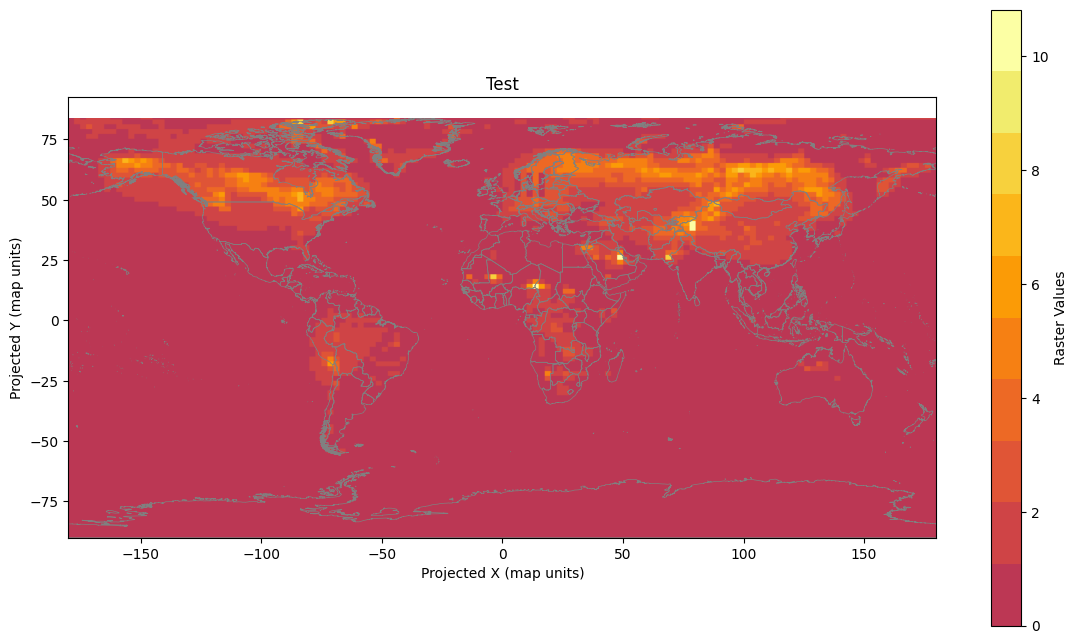

In [13]:
mp.plot_raster_on_world_extremes_cutoff(so2_raster_fp, title="Test", perc_cutoff=0, quantiles=10, cmap="inferno")

Now plotting

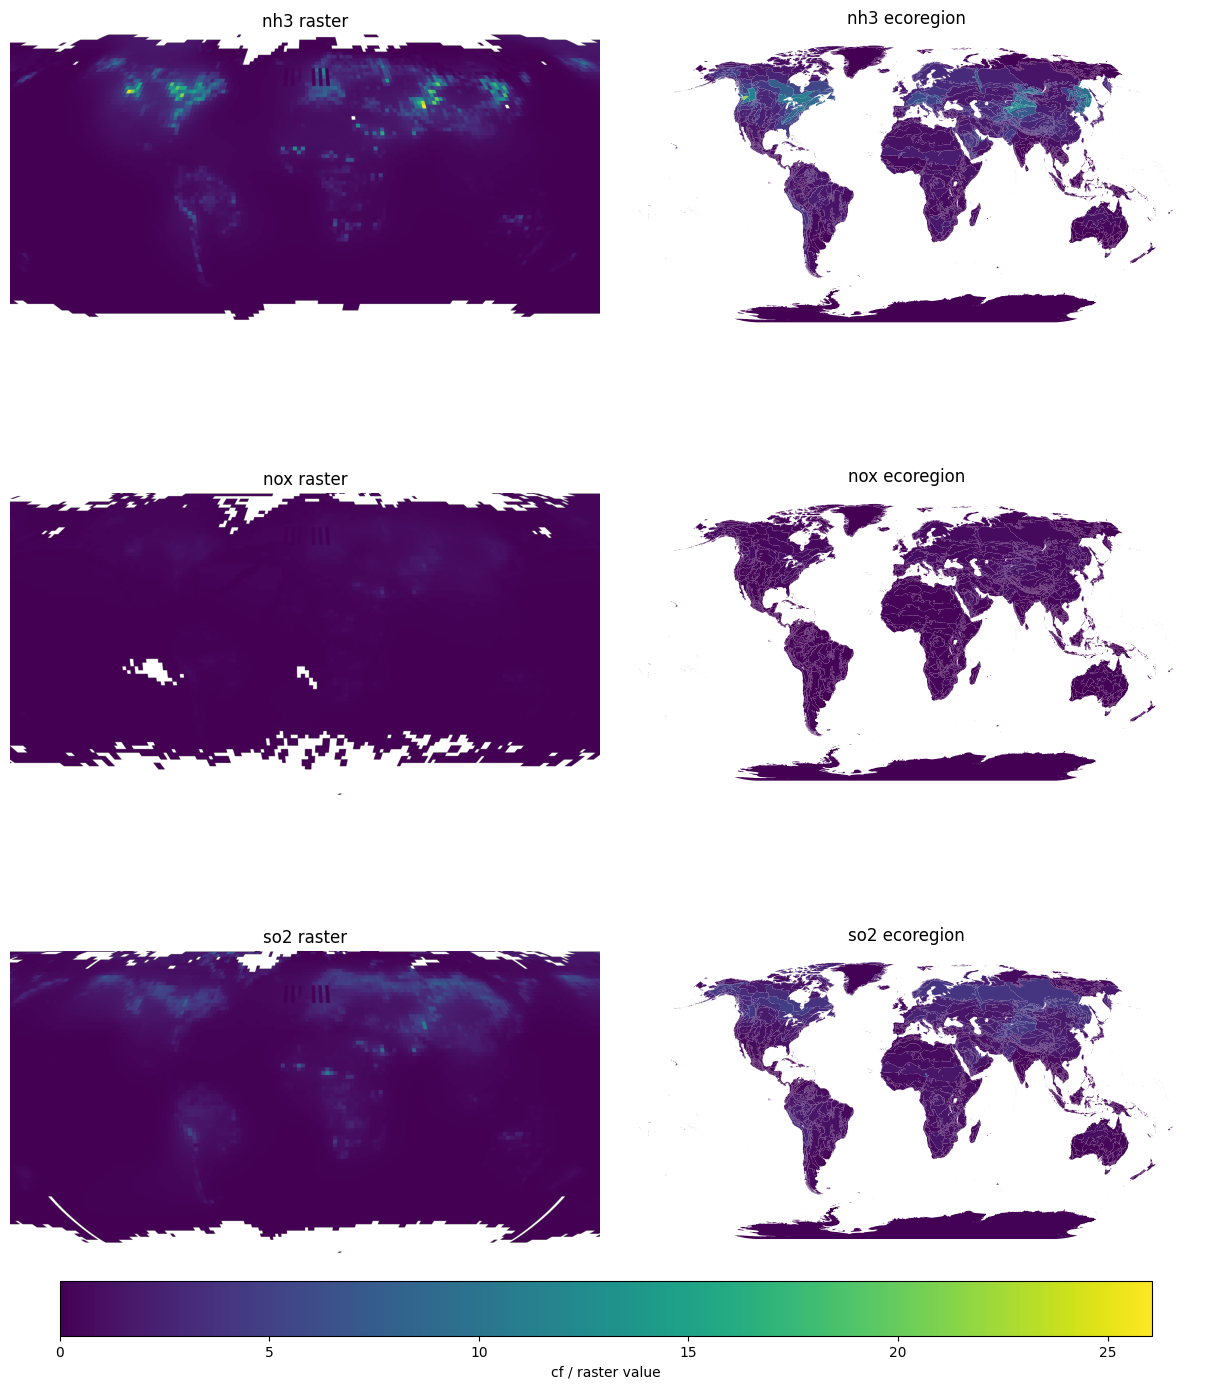

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# paths for reprojected natearth rasters (written in an earlier cell)
nh3_ne_fp = "../paper/acid_nh3_natear.tif"
nox_ne_fp = "../paper/acid_nox_natear.tif"
so2_ne_fp = "../paper/acid_so2_natear.tif"

# open rasters (rioxarray already imported as rxr)
da_nh3 = rxr.open_rasterio(nh3_ne_fp, masked=True)
da_nox = rxr.open_rasterio(nox_ne_fp, masked=True)
da_so2 = rxr.open_rasterio(so2_ne_fp, masked=True)

# helper: always return a 2D float array with NaNs
def _arr2d(da):
    arr = da.squeeze().values  # (y,x) or (band,y,x) depending on file
    if arr.ndim == 3:
        arr = arr[0]
    if np.ma.isMaskedArray(arr):
        arr = arr.filled(np.nan)
    return arr.astype("float64", copy=False)

arrs = [_arr2d(da_nh3), _arr2d(da_nox), _arr2d(da_so2)]

# get cf values for each flow
flows = ["nh3", "nox", "so2"]
cf_vals = [
    acid_er_ne.loc[acid_er_ne["flow_name"] == f, "cf"].to_numpy(dtype="float64")
    for f in flows
]

# shared vmin/vmax across rasters and cf values
all_vals = np.concatenate([a.ravel() for a in arrs] + [v.ravel() for v in cf_vals])
all_vals = all_vals[np.isfinite(all_vals)]
vmin, vmax = all_vals.min(), all_vals.max()

# plotting
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 15), constrained_layout=True)

cmap = "viridis"
das = [da_nh3, da_nox, da_so2]

for i, flow in enumerate(flows):
    ax_r = axes[i, 0]
    ax_m = axes[i, 1]

    da = das[i]
    arr = arrs[i]

    # mask zeros (do not plot them)
    arr = np.where(arr == 0, np.nan, arr)

    # extent from coordinates (convert to plain numpy floats)
    x0 = float(da["x"].values.min())
    x1 = float(da["x"].values.max())
    y0 = float(da["y"].values.min())
    y1 = float(da["y"].values.max())
    extent = (x0, x1, y0, y1)

    ax_r.imshow(arr, cmap=cmap, vmin=vmin, vmax=vmax, extent=extent, origin="upper")
    ax_r.set_title(f"{flow} raster")
    ax_r.set_axis_off()

    subset = acid_er_ne[acid_er_ne["flow_name"] == flow]
    subset.plot(column="cf", ax=ax_m, cmap=cmap, vmin=vmin, vmax=vmax, edgecolor="none")
    ax_m.set_title(f"{flow} ecoregion")
    ax_m.set_axis_off()

# shared colorbar (don’t rely on a particular imshow handle)
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])

cbar = fig.colorbar(sm, ax=axes.ravel().tolist(), orientation="horizontal", fraction=0.04, pad=0.02)
cbar.set_label("cf / raster value")

plt.show()

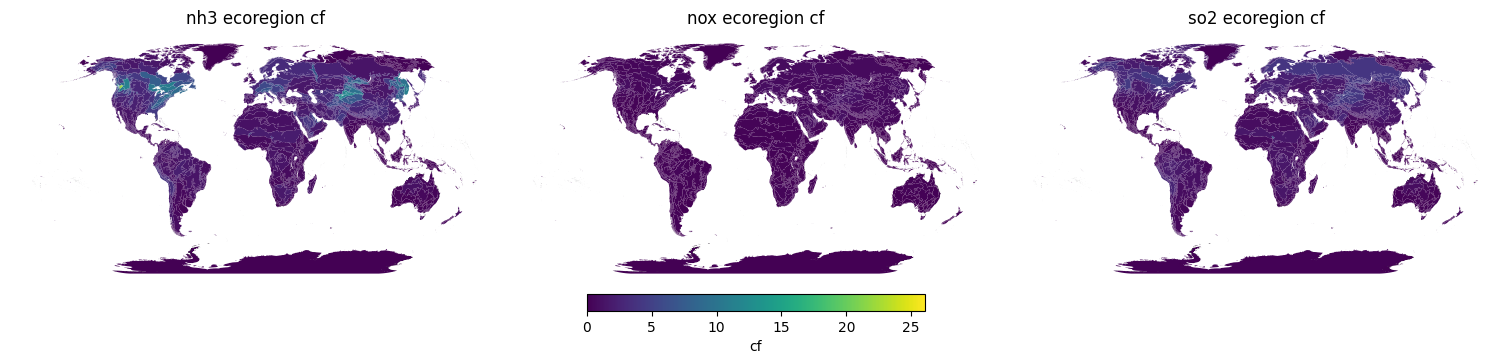

In [ ]:
# plot cf for each flow_name (shared vmin/vmax and cmap from previous cells)
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5), constrained_layout=True)

for ax, flow in zip(axes.ravel(), flows):
    subset = acid_er_ne[acid_er_ne["flow_name"] == flow]
    subset.plot(column="cf", ax=ax, cmap=cmap, vmin=vmin, vmax=vmax, edgecolor="none")
    ax.set_title(f"Terrestrial Acidification LEAFs by Ecoregion - {flow}")
    ax.set_axis_off()

# shared colorbar
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
fig.colorbar(sm, ax=axes.ravel().tolist(), orientation="horizontal", fraction=0.04, pad=0.02).set_label("LEAF [kg SO2-eq./kg]")

plt.show()